In [ ]:
import spacy
import pandas as pd
import torch

/home/tanmay/Work/IT549/Lab_1/Imitating-Fakespot/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
df = pd.read_csv('fake_reviews_dataset.csv')
df.head()
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  str    
 1   rating    40432 non-null  float64
 2   label     40432 non-null  str    
 3   text_     40432 non-null  str    
dtypes: float64(1), str(3)
memory usage: 1.2 MB


In [18]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [29]:
for category in df["category"].unique():
    print(f"Category: {category}")
    print(df["category"].value_counts()[category])

nlp = spacy.load("en_core_web_sm")

Category: Home_and_Kitchen_5
4056
Category: Sports_and_Outdoors_5
3946
Category: Electronics_5
3988
Category: Movies_and_TV_5
3588
Category: Tools_and_Home_Improvement_5
3858
Category: Pet_Supplies_5
4254
Category: Kindle_Store_5
4730
Category: Books_5
4370
Category: Toys_and_Games_5
3794
Category: Clothing_Shoes_and_Jewelry_5
3848


In [ ]:
def preprocess_text(text):
    doc = nlp(text.lower())

    tokens = [ token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    return " ".join(tokens)

df["clean_text"] = df["text_"].apply(preprocess_text)



In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x.split(),
    max_features=5000
)

X = vectorizer.fit_transform(df["clean_text"])



/home/tanmay/Work/IT549/Lab_1/Imitating-Fakespot/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = vectorizer.fit_transform(df["clean_text"])
X = vectorizer.fit_transform(df["clean_text"])

le = LabelEncoder()
y = le.fit_transform(df["label"])

categories = df["category"].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, cat_train, cat_test = train_test_split(
    X, y, categories,
    test_size=0.2,
    random_state=42
)

X_train = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test = torch.tensor(X_test.toarray(), dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape, y_train.shape)


/home/tanmay/Work/IT549/Lab_1/Imitating-Fakespot/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


torch.Size([32345, 5000]) torch.Size([32345])


In [91]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)   
        )

    def forward(self, x):
        return self.model(x).squeeze(1)


input_dim = X_train.shape[1]
num_classes = len(torch.unique(y_train))

model = MLP(input_dim)


In [92]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



MLP(
  (model): Sequential(
    (0): Linear(in_features=5000, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [93]:
epochs = 12

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")



Epoch 1, Loss: 397.1820
Epoch 2, Loss: 126.4761
Epoch 3, Loss: 69.4318
Epoch 4, Loss: 59.7804
Epoch 5, Loss: 55.1061
Epoch 6, Loss: 49.7662
Epoch 7, Loss: 41.6883
Epoch 8, Loss: 44.3174
Epoch 9, Loss: 44.4410
Epoch 10, Loss: 38.1852
Epoch 11, Loss: 53.2761
Epoch 12, Loss: 61.6035


In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test, y_test),
    batch_size=32,
    shuffle=False
)
def evaluate(model, data_loader, device):
    model.eval()
    
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            outputs = model(xb)
            probs = torch.sigmoid(outputs)

            preds = (probs > 0.5).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"ROC-AUC   : {roc_auc:.4f}")

    return acc, prec, rec, f1, roc_auc

evaluate(model, test_loader, device)


Accuracy  : 0.6512
Precision : 0.7400
Recall    : 0.4733
F1 Score  : 0.5774
ROC-AUC   : 0.6605


(0.6511685421046124,
 0.7400153609831029,
 0.47334807172684845,
 0.577378277153558,
 0.6605184824445769)

In [95]:
def get_predictions(model, data_loader, device):
    model.eval()

    all_probs = []
    all_preds = []

    with torch.no_grad():
        for xb, _ in data_loader:
            xb = xb.to(device)
            outputs = model(xb)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_probs), np.array(all_preds)


In [96]:
probs, preds = get_predictions(model, test_loader, device)

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

results = []

for category in np.unique(cat_test):
    idx = (cat_test == category)

    acc = accuracy_score(y_test[idx], preds[idx])
    f1 = f1_score(y_test[idx], preds[idx])

    results.append({
        "Category": category,
        "Samples": idx.sum(),
        "Accuracy": acc,
        "F1 Score": f1
    })

results_df = pd.DataFrame(results).sort_values("F1 Score", ascending=False)

print(results_df)


                       Category  Samples  Accuracy  F1 Score
2                 Electronics_5      760  0.676316  0.639296
7         Sports_and_Outdoors_5      802  0.675810  0.628571
8  Tools_and_Home_Improvement_5      711  0.676512  0.610169
6                Pet_Supplies_5      867  0.673587  0.598582
3            Home_and_Kitchen_5      847  0.651712  0.588563
1  Clothing_Shoes_and_Jewelry_5      746  0.651475  0.583333
9              Toys_and_Games_5      733  0.646658  0.578862
5               Movies_and_TV_5      735  0.647619  0.573311
0                       Books_5      915  0.621858  0.512676
4                Kindle_Store_5      971  0.605561  0.471724


In [99]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(text, title):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200
    ).generate(text)

    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()


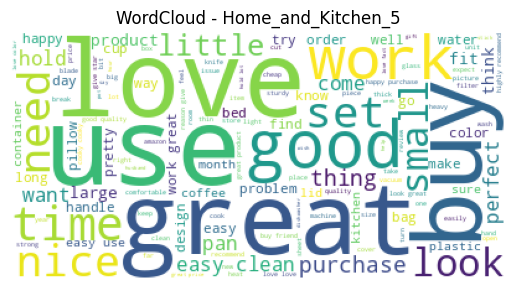

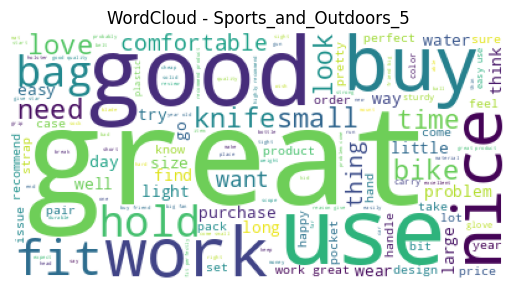

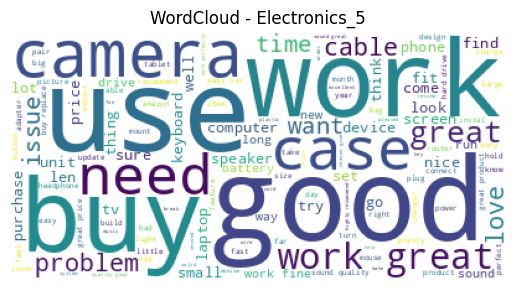

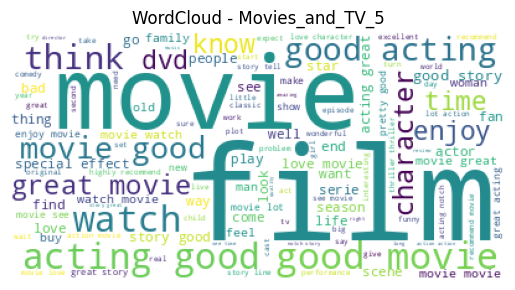

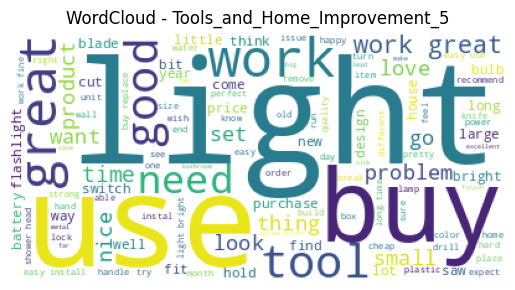

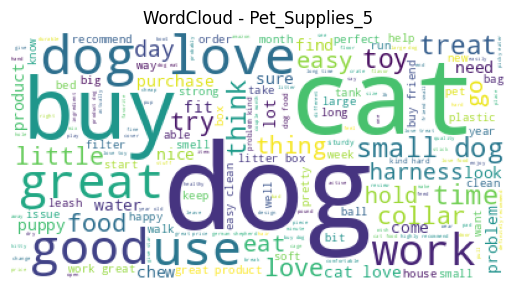

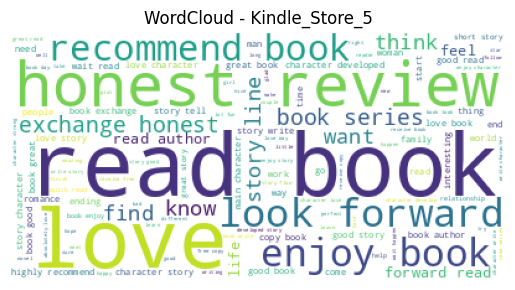

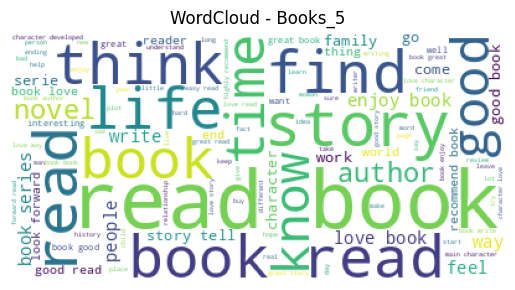

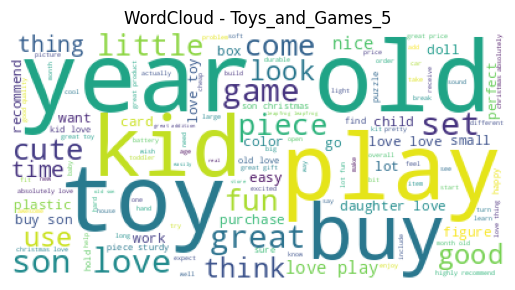

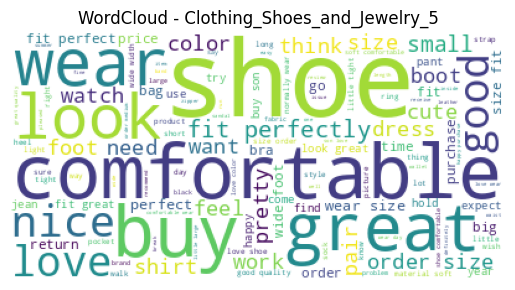

In [100]:
for category in df["category"].unique():
    text = " ".join(
        df[df["category"] == category]["clean_text"]
    )
    plot_wordcloud(text, f"WordCloud - {category}")
